#### Objective

In this notebook......

#### Preliminaries - import main libraries

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from skimage import segmentation, color
from skimage.color import rgb2gray 

from skimage.morphology import disk, square, closing, opening, erosion, dilation
from skimage.morphology import reconstruction, remove_small_objects

%matplotlib inline

In [2]:
import requests
from PIL import Image
from StringIO import StringIO

#### Import test image

In [3]:
url = 'https://raw.githubusercontent.com/mycarta/rainbowbot/master/stuff4matching_cmap_notebooks/test1.png'
#url = 'https://raw.githubusercontent.com/mycarta/rainbowbot/master/stuff4matching_cmap_notebooks/test2.png'
#url = 'http://localhost:8889/files/Desktop/GitHub/rainbowbot/stuff4matching_cmap_notebooks/test_with_text.png'

r = requests.get(url)
img = np.asarray(Image.open(StringIO(r.content)).convert('RGB'))

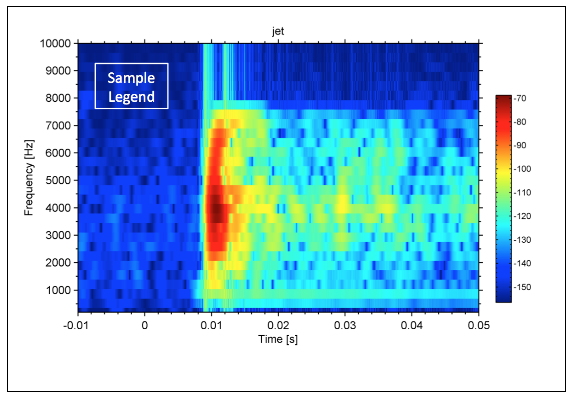

In [4]:
# plot image
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
plt.imshow(img)
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
plt.show()

#### Find the map

We want to eliminate both possibilities of ~black and ~nearly white border

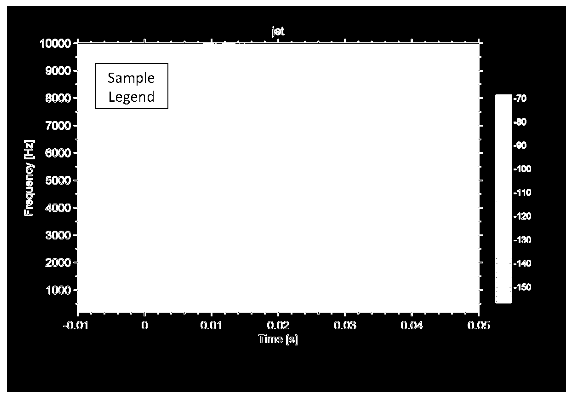

In [5]:
binary = np.logical_and(color.rgb2gray(img) > 0.02, color.rgb2gray(img) < 0.98)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#### If present, label and remove small bright objects like text  

This would be blocks of text not related - like tick marks - to the figure

In [6]:
label_objects, nb_labels = sp.ndimage.label(binary)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 30 # have to make structuring element size based on image size heuristic
mask_sizes[0] = 0
cleaned = mask_sizes[label_objects]

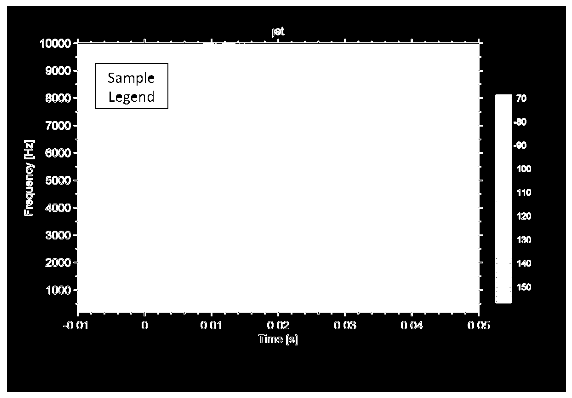

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(cleaned, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#### Close small gaps

If present, eliminates small dar spots with closing

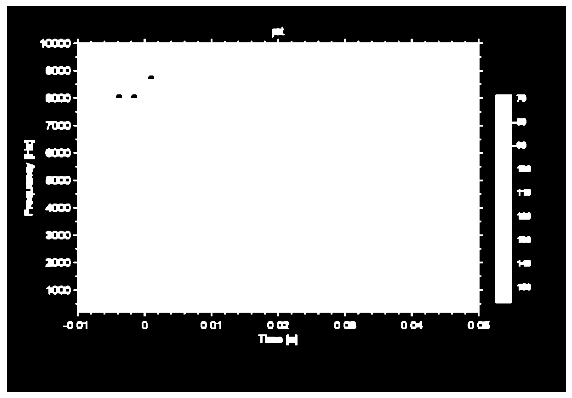

In [8]:
closed = closing(cleaned, square(5))  # have to make structuring element size based on image size heuristic

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(closed, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#### Get largest element in ghe binary image and use it as a mask for the original image

Detect largest bright element in the binary image. Making the assumption it would be the map.
This should also take care of any remaining small bright elements not removed with opening.

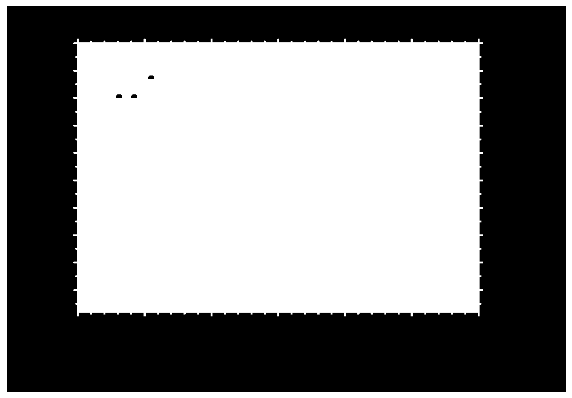

In [9]:
# label all white objects ( made up of ones)
label_objects, nb_labels = sp.ndimage.label(closed) 

# calculate every labeled object's size
sizes = np.bincount(label_objects.ravel())             

# keep only largest object
mask_sizes = sizes == max(sizes)                                
mask_sizes[0] = 0                                        
binary_cleaned = mask_sizes[label_objects]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary_cleaned, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

In [10]:
# convert it to a 3D array mask to use in next cell

mask3 = np.zeros(img.shape)
mask3[:,:,0] = binary_cleaned
mask3[:,:,1] = binary_cleaned
mask3[:,:,2] = binary_cleaned

In [11]:
# use the mask to get only the map in the original image
final = np.ma.masked_where(mask3 == False, img)
final = final.filled(0)

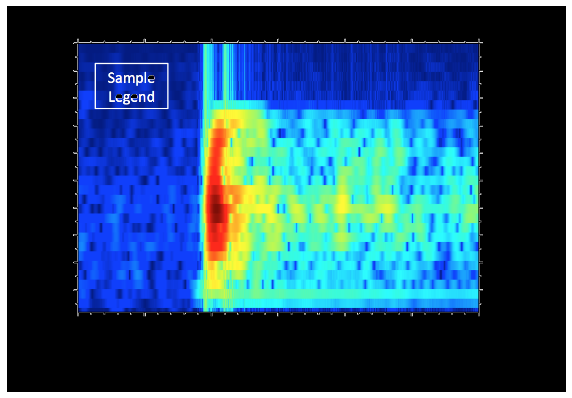

In [12]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(final)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#### Crop zero columns and zero rows

http://stackoverflow.com/a/14211727/1034648

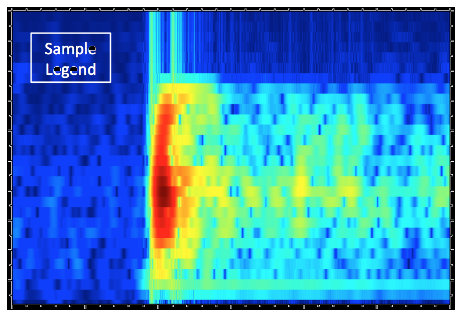

In [13]:
non_empty_columns = np.where(final.max(axis=0)>0)[0]
non_empty_rows = np.where(final.max(axis=1)>0)[0]
cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))

final_crop = final[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.imshow(final_crop, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

N.B. It seems to work even when the map touches the border, as in:
https://raw.githubusercontent.com/mycarta/rainbowbot/master/stuff4matching_cmap_notebook/test2.png

#### Reduce number of colours

I use here Scikit-learn segmentation using k-means clustering in Color-(x,y,z) space:
http://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic

In [14]:
labels1 = segmentation.slic(final_crop, compactness=30, n_segments=32, convert2lab = 'True') 
out1 = color.label2rgb(labels1, final_crop, kind='avg')

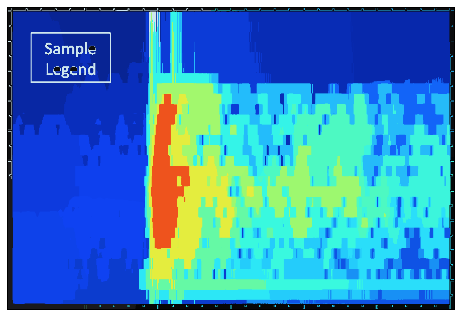

In [15]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.imshow(out1)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()